In [ ]:
!unzip "/content/drive/MyDrive/DataN1.zip" -d "/content/drive/MyDrive/DataN9"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1294_virus_2221.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1294_virus_2222.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1295_bacteria_3258.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1295_virus_2223.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1297_bacteria_3260.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1298_virus_2226.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1298_virus_2228.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person12_bacteria_47.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person12_bacteria_48.jpeg  
  inflating: /content/drive/MyDrive/DataN9/DataN1/data/train/person1300_bacteria_3264.jpeg  
  inflating: /content/drive/MyDrive/DataN9

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.metrics import Precision, Recall
import joblib

import warnings
warnings.filterwarnings('ignore')

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/DataN9/DataN1/labels.csv')

In [ ]:
labels

,image_path,label
0,COVID-19 (1).jpg,Covid
1,COVID-19 (10).jpg,Covid
2,COVID-19 (102).jpg,Covid
3,COVID-19 (103).jpg,Covid
4,COVID-19 (104).jpg,Covid
...,...,...
17699,person99_bacteria_473.jpeg,PNEUMONIA
17700,person99_bacteria_474.jpeg,PNEUMONIA
17701,person9_bacteria_39.jpeg,PNEUMONIA
17702,person9_bacteria_40.jpeg,PNEUMONIA


In [ ]:
train_df_path = "/content/drive/MyDrive/DataN9/DataN1/train_labels.csv"
test_df_path = "/content/drive/MyDrive/DataN9/DataN1/test_labels.csv"
train_path = '/content/drive/MyDrive/DataN9/DataN1/data/train'
test_path = '/content/drive/MyDrive/DataN9/DataN1/data/test'

train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

In [ ]:
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

# Training data generator
train_generator = gen.flow_from_dataframe(
    train_df,  # dataframe
    directory=train_path,  # images data path / folder in which images are there
    x_col='image_path',
    y_col='label',
    color_mode="rgb",
    target_size=(331, 331),  # image height, image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator = gen.flow_from_dataframe(
    test_df,  # dataframe
    directory=test_path,  # images data path / folder in which images are there
    x_col='image_path',
    y_col='label',
    color_mode="rgb",
    target_size=(331, 331),  # image height, image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 12351 validated image filenames belonging to 4 classes.
Found 5353 validated image filenames belonging to 4 classes.


In [ ]:
x,y = next(train_generator)
x.shape

(32, 331, 331, 3)

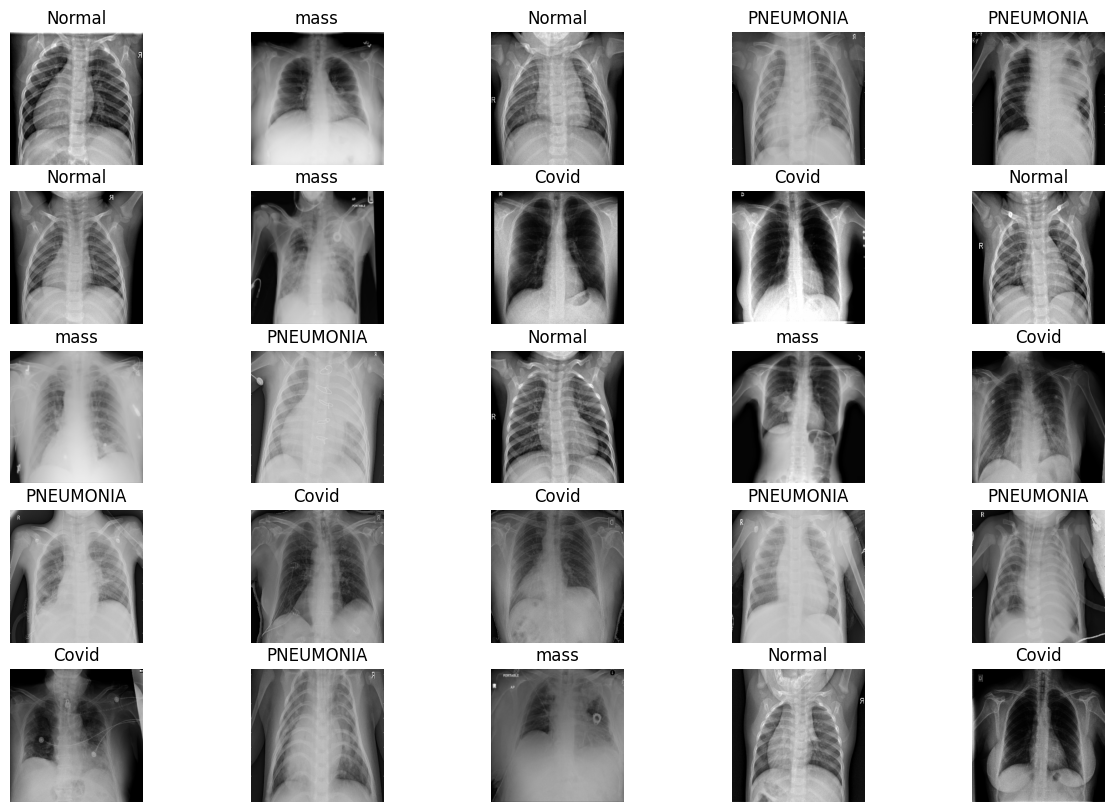

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys())

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i],cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# DenesNet19

In [ ]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(331, 331, 3)  # Adjust input shape according to your dataset
)

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # Adjust the number of output classes
])

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 10, 10, 1024)      7037504   
                                                                 
 batch_normalization (Batch  (None, 10, 10, 1024)      4096      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras.utils as plot_utils

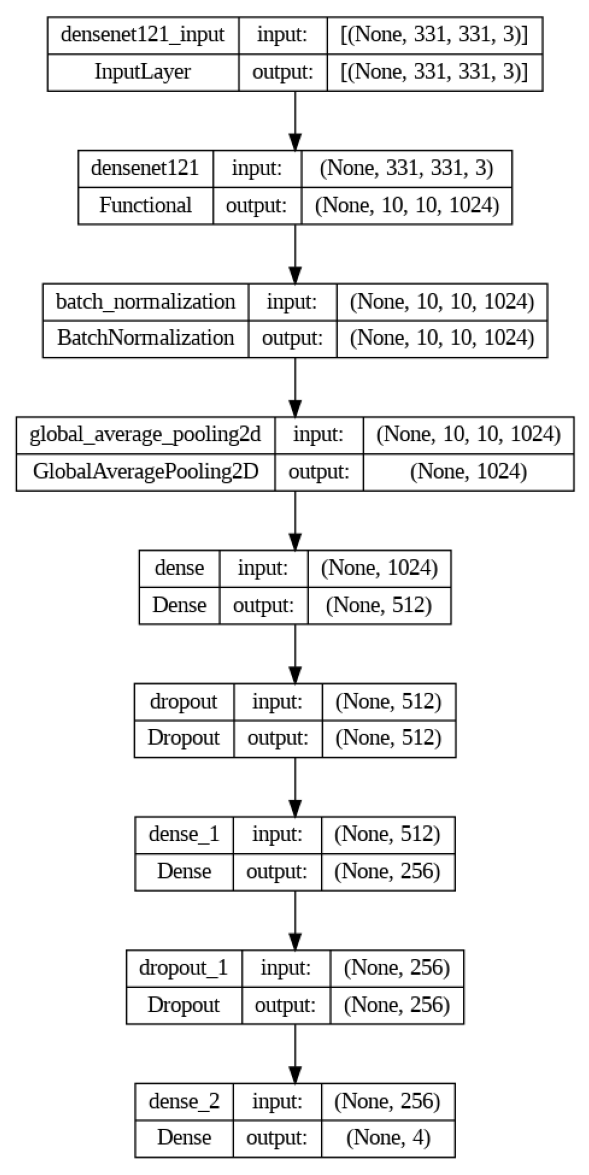

In [ ]:
plot_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the architecture image
architecture_img = plt.imread('model_plot.png')
plt.figure(figsize=(10, 15))
plt.imshow(architecture_img)
plt.axis('off')
plt.show()

In [ ]:
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10,
                                              min_delta=0.001,
                                              restore_best_weights=True)

# Define ModelCheckpoint callback to save the best model
checkpoint_path = "IR.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

In [ ]:
batch_size = 32
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[early_stop, checkpoint])

Epoch 1/15
385/385 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9439 - precision: 0.9519 - recall: 0.9319
Epoch 1: val_accuracy improved from -inf to 0.96707, saving model to IR.h5
385/385 [==============================] - 426s 1s/step - loss: 0.1798 - accuracy: 0.9439 - precision: 0.9519 - recall: 0.9319 - val_loss: 0.0956 - val_accuracy: 0.9671 - val_precision: 0.9688 - val_recall: 0.9659
Epoch 2/15
385/385 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9645 - precision: 0.9657 - recall: 0.9631
Epoch 2: val_accuracy improved from 0.96707 to 0.96931, saving model to IR.h5
385/385 [==============================] - 401s 1s/step - loss: 0.1056 - accuracy: 0.9645 - precision: 0.9657 - recall: 0.9631 - val_loss: 0.0870 - val_accuracy: 0.9693 - val_precision: 0.9718 - val_recall: 0.9673
Epoch 3/15
385/385 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9711 - precision: 0.9726 - recall: 0.9700
Epoch 3: val_accurac

In [ ]:
import joblib

# Save the model using joblib
joblib.dump(model, 'DenseNet121.pkl')


['DenseNet121.pkl']

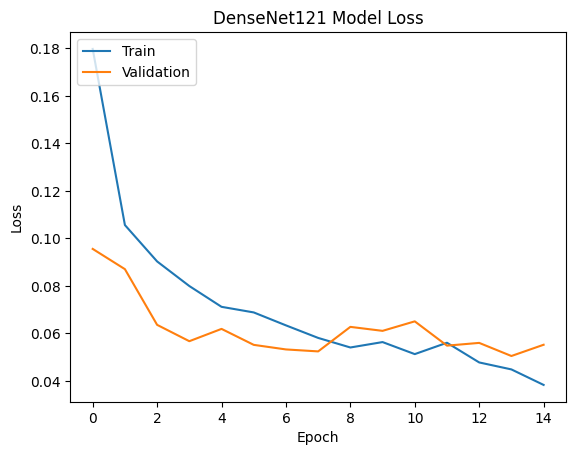

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet121 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

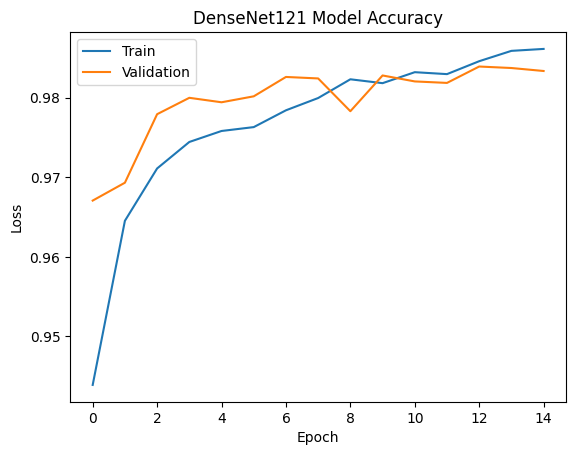

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet121 Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on validation data
validation_predictions = model.predict(validation_generator)

# Get true labels
true_labels = validation_generator.classes

# Get predicted labels
predicted_labels = np.argmax(validation_predictions, axis=1)

# Define class names
class_names = ['mass', 'Normal', 'PNEUMONIA', 'Covid']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix


168/168 [==============================] - 95s 550ms/step


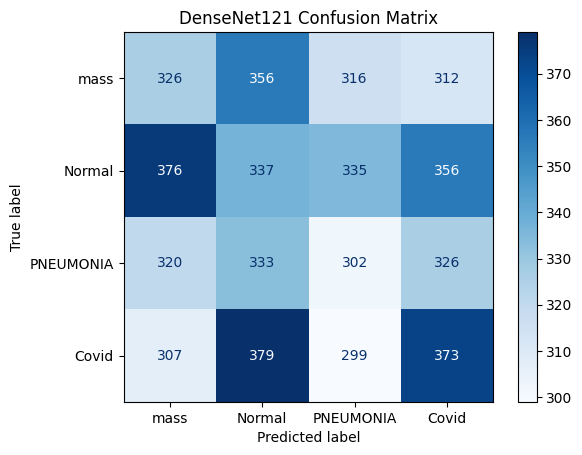

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('DenseNet121 Confusion Matrix')
plt.show()

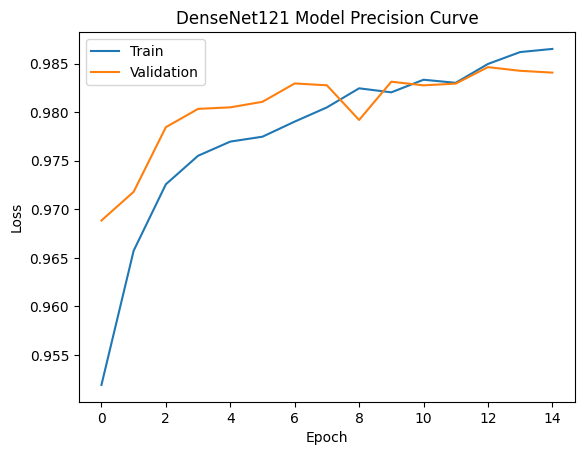

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('DenseNet121 Model Precision Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

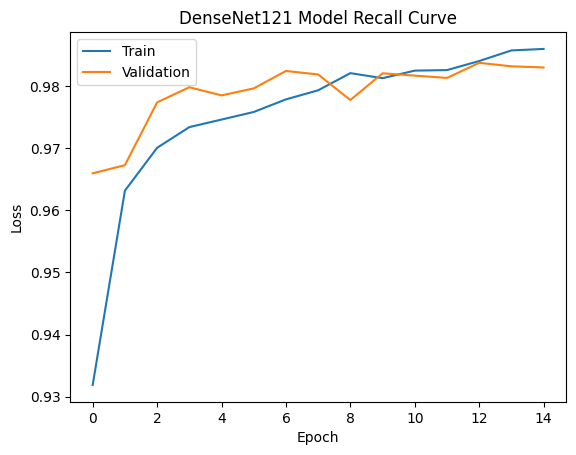

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('DenseNet121 Model Recall Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# EfficientNetB7

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.EfficientNetB7(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # Adjust the output units based on the number of classes
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 11, 11, 2560)      64097687  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 2560)      10240     
 chNormalization)                                                
                                                                 
 global_average_pooling2d_1  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               1311232   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                        

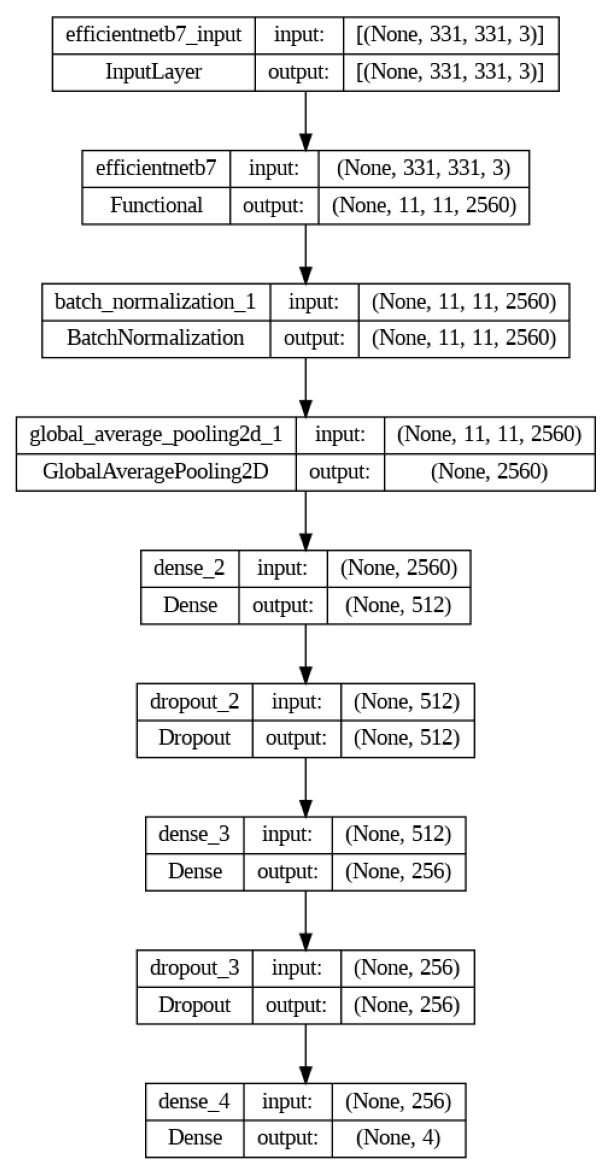

In [ ]:
plot_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the architecture image
architecture_img = plt.imread('model_plot.png')
plt.figure(figsize=(10, 15))
plt.imshow(architecture_img)
plt.axis('off')
plt.show()

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10,
                                              min_delta=0.001,
                                              restore_best_weights=True)

# Define ModelCheckpoint callback to save the best model
checkpoint_path = "EfficientNetB7.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

In [ ]:
batch_size = 32
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks=[early_stop, checkpoint])

Epoch 1/15
385/385 [==============================] - ETA: 0s - loss: 1.4112 - accuracy: 0.2758 - precision: 0.2749 - recall: 0.0085
Epoch 1: val_accuracy improved from -inf to 0.28967, saving model to EfficientNetB7.h5
385/385 [==============================] - 493s 1s/step - loss: 1.4112 - accuracy: 0.2758 - precision: 0.2749 - recall: 0.0085 - val_loss: 1.3806 - val_accuracy: 0.2897 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
385/385 [==============================] - ETA: 0s - loss: 1.3801 - accuracy: 0.2960 - precision: 0.4777 - recall: 0.0087
Epoch 2: val_accuracy improved from 0.28967 to 0.45341, saving model to EfficientNetB7.h5
385/385 [==============================] - 452s 1s/step - loss: 1.3801 - accuracy: 0.2960 - precision: 0.4777 - recall: 0.0087 - val_loss: 1.3418 - val_accuracy: 0.4534 - val_precision: 0.5102 - val_recall: 0.0047
Epoch 3/15
385/385 [==============================] - ETA: 0s - loss: 1.3687 - accuracy: 0.3060 - precision: 0.5159 - rec

In [ ]:
joblib.dump(model, 'EfficientNetB7.pkl')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('EfficientNetB7 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('EfficientNetB7 Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('EfficientNetB7 Model Precision Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('EfficientNetB7 Model Recall Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
validation_predictions = model.predict(validation_generator)
true_labels = validation_generator.classes
predicted_labels = np.argmax(validation_predictions, axis=1)
class_names = ['mass', 'Normal', 'PNEUMONIA', 'Covid']
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('EfficientNetB7 Confusion Matrix')
plt.show()